# step 0. 필요 라이브러리 import

In [3]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import train_test_split

# step 1. 모든 단어 사용

1. 데이터 다운

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2. 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


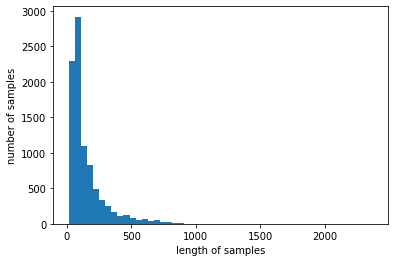

In [3]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

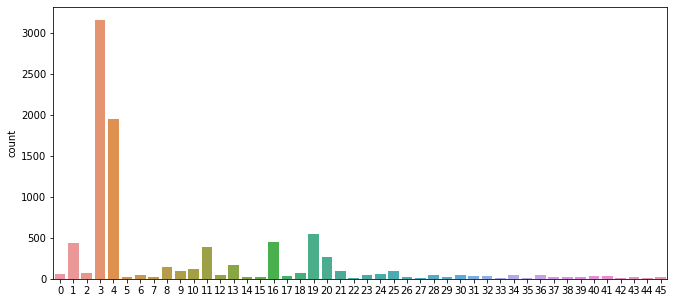

In [4]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

3. 데이터 복원

'단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary -> word_index로 저장

In [5]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

(pad, sos, unk)특별한 토큰 매핑

In [6]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

데이터셋 문자로 복원

In [7]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

print(len(x_train))
print('x_train[5]: ', x_train[:5])

8982
x_train[5]:  ['<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', "<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo factors' turnover in 1986 was 17 5 billion belgian francs reuter 3", '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per 

In [8]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))
print('x_test[5]: ', x_test[:5])

2246
x_test[5]:  ['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt tengelmann warenhandelsgesellschaft of west germany reuter 3', "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman arse

4. 벡터화(DTM, TF-IDF 행렬 사용)

DTM 생성

In [9]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


TF-IDF Matrix 생성

In [10]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


테스트 데이터의 TF-IDF Matrix 생성

In [11]:
#테스트 데이터를 DTM으로 변환
x_test_dtm = dtmvector.transform(x_test)

#DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

5. 모델 학습 및 예측, 평가

나이브 베이즈 분류기

In [12]:
# 모델 정의 및 훈련
nb = MultinomialNB()
nb.fit(tfidfv, y_train)

MultinomialNB()

In [13]:
#테스트 데이터에 대한 예측
predicted = nb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.5997328584149599


In [14]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29        99
          17       0.00    

In [15]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.5045670886188423


CNB

In [16]:
# 모델 정의 및 훈련
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [17]:
#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


In [18]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.63      0.88      0.73       105
           2       0.91      0.50      0.65        20
           3       0.87      0.91      0.89       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.43      0.08      0.13        38
           9       0.81      0.88      0.85        25
          10       0.96      0.73      0.83        30
          11       0.55      0.67      0.61        83
          12       0.00      0.00      0.00        13
          13       0.62      0.54      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.77      0.71        99
          17       0.00    

In [19]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7346534179503126


로지스틱 회귀

In [20]:
# 모델 정의 및 훈련
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [21]:
#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8165627782724845


In [22]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.79      0.77       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.85      0.88      0.86        25
          10       0.93      0.90      0.92        30
          11       0.67      0.72      0.69        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.71      0.77      0.74        99
          17       0.82    

In [23]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.8114428402876209


서포트 벡터 머신

In [24]:
# 모델 정의 및 훈련
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [25]:
#테스트 데이터에 대한 예측
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7916295636687445


In [26]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.74      0.77      0.76       105
           2       0.62      0.65      0.63        20
           3       0.91      0.92      0.92       813
           4       0.82      0.86      0.84       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.59      0.71      0.64        38
           9       0.84      0.84      0.84        25
          10       0.83      0.80      0.81        30
          11       0.67      0.75      0.71        83
          12       0.33      0.31      0.32        13
          13       0.61      0.59      0.60        37
          14       1.00      0.50      0.67         2
          15       0.57      0.44      0.50         9
          16       0.65      0.75      0.70        99
          17       0.67    

In [27]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7870524130224487


결정 트리

In [28]:
# 모델 정의 및 훈련
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [29]:
#테스트 데이터에 대한 예측
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


In [30]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.69      0.43      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.85      0.89       813
           4       0.40      0.89      0.55       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.89      0.80      0.84        30
          11       0.58      0.60      0.59        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.83      0.70        99
          17       0.00    

In [31]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.5769283128518846


랜덤 포레스트

In [32]:
# 모델 정의 및 훈련
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [33]:
#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


In [34]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.25      0.58      0.35        12
           1       0.35      0.60      0.44       105
           2       0.32      0.40      0.36        20
           3       0.82      0.89      0.85       813
           4       0.62      0.84      0.71       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.51      0.47      0.49        38
           9       1.00      0.28      0.44        25
          10       0.46      0.20      0.28        30
          11       0.56      0.64      0.60        83
          12       0.40      0.15      0.22        13
          13       0.33      0.16      0.22        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.46      0.52        99
          17       0.00    

In [35]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.6225909375608356


그래디언트 부스팅 트리

In [36]:
# 모델 정의 및 훈련
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [37]:
#테스트 데이터에 대한 예측
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


In [38]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.81      0.71      0.76       105
           2       0.58      0.70      0.64        20
           3       0.87      0.91      0.89       813
           4       0.78      0.86      0.82       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.60      0.63      0.62        38
           9       0.91      0.80      0.85        25
          10       0.79      0.77      0.78        30
          11       0.61      0.65      0.63        83
          12       0.50      0.46      0.48        13
          13       0.48      0.32      0.39        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.72      0.71      0.71        99
          17       0.83    

In [39]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7641672650539437


보팅

In [40]:
# 개별 분류기 정의
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
complement_nb = ComplementNB()
gradient_boost = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('lr', log_reg), ('cnb', complement_nb), ('gb', gradient_boost)],
    voting='soft'
)

voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('cnb', ComplementNB()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [41]:
#테스트 데이터에 대한 예측
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7956366874443455


In [42]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.79      0.81      0.80       105
           2       0.74      0.70      0.72        20
           3       0.91      0.93      0.92       813
           4       0.77      0.88      0.82       474
           5       0.50      0.20      0.29         5
           6       0.83      0.71      0.77        14
           7       1.00      0.33      0.50         3
           8       0.67      0.68      0.68        38
           9       0.91      0.80      0.85        25
          10       0.83      0.80      0.81        30
          11       0.68      0.69      0.68        83
          12       0.55      0.46      0.50        13
          13       0.66      0.57      0.61        37
          14       0.00      0.00      0.00         2
          15       0.25      0.11      0.15         9
          16       0.75      0.73      0.74        99
          17       0.71    

In [43]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7895657638554769


# step 2. 빈도수 상위 5,000개의 단어만 사용

1. 데이터 다운

In [44]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

2. 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


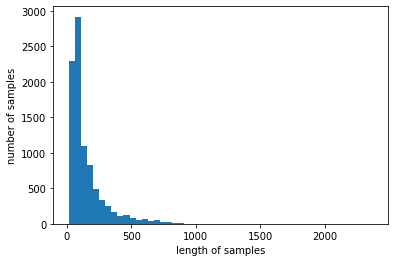

In [45]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

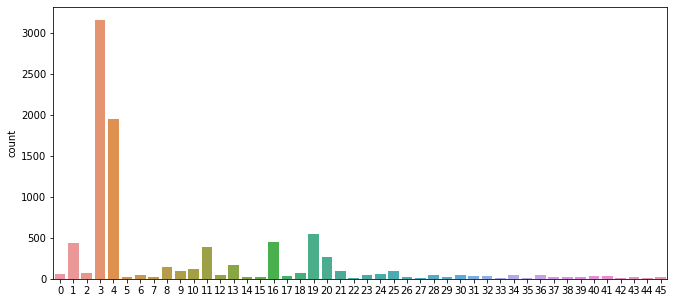

In [46]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

3. 데이터 복원

'단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary -> word_index로 저장

In [47]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

(pad, sos, unk)특별한 토큰 매핑

In [48]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

데이터셋 문자로 복원

In [49]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

print(len(x_train))
print('x_train[5]: ', x_train[:5])

8982
x_train[5]:  ['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt <unk> <unk> and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share re

In [50]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))
print('x_test[5]: ', x_test[:5])

2246
x_test[5]:  ['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3', "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> <unk> said <unk> told reuters a survey

4. 벡터화(DTM, TF-IDF 행렬 사용)

DTM 생성

In [51]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


TF-IDF Matrix 생성

In [52]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


테스트 데이터의 TF-IDF Matrix 생성

In [53]:
#테스트 데이터를 DTM으로 변환
x_test_dtm = dtmvector.transform(x_test)

#DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

5. 모델 학습 및 예측, 평가

나이브 베이즈 분류기

In [54]:
# 모델 정의 및 훈련
nb = MultinomialNB()
nb.fit(tfidfv, y_train)

MultinomialNB()

In [55]:
#테스트 데이터에 대한 예측
predicted = nb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6731967943009796


In [56]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99
          17       0.00    

In [57]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.6012501291711391


CNB

In [58]:
# 모델 정의 및 훈련
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [59]:
#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


In [60]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.63      0.86      0.73       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.74      0.92      0.82       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.57      0.21      0.31        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.76      0.63        83
          12       0.00      0.00      0.00        13
          13       0.69      0.59      0.64        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.67      0.79      0.72        99
          17       0.00    

In [61]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7458990404916549


로지스틱 회귀

In [62]:
# 모델 정의 및 훈련
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [63]:
#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8036509349955476


In [64]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.77      0.75       105
           2       0.76      0.80      0.78        20
           3       0.90      0.93      0.91       813
           4       0.80      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.66      0.71      0.68        38
           9       0.81      0.88      0.85        25
          10       0.89      0.83      0.86        30
          11       0.64      0.73      0.69        83
          12       0.57      0.31      0.40        13
          13       0.63      0.65      0.64        37
          14       0.50      0.50      0.50         2
          15       0.75      0.33      0.46         9
          16       0.70      0.75      0.73        99
          17       0.80    

In [65]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7985602317931111


서포트 벡터 머신

In [66]:
# 모델 정의 및 훈련
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [67]:
#테스트 데이터에 대한 예측
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7729296527159395


In [68]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.75      0.72      0.73       105
           2       0.75      0.75      0.75        20
           3       0.89      0.90      0.90       813
           4       0.81      0.82      0.82       474
           5       0.00      0.00      0.00         5
           6       0.81      0.93      0.87        14
           7       0.50      0.33      0.40         3
           8       0.59      0.71      0.64        38
           9       0.81      0.84      0.82        25
          10       0.79      0.77      0.78        30
          11       0.64      0.73      0.68        83
          12       0.33      0.31      0.32        13
          13       0.55      0.62      0.58        37
          14       0.50      1.00      0.67         2
          15       0.40      0.22      0.29         9
          16       0.65      0.71      0.68        99
          17       0.88    

In [69]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7694057464576125


결정 트리

In [70]:
# 모델 정의 및 훈련
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [71]:
#테스트 데이터에 대한 예측
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


In [72]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.40      0.52       105
           2       0.60      0.45      0.51        20
           3       0.94      0.84      0.89       813
           4       0.39      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       1.00      0.57      0.73        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.87      0.87      0.87        30
          11       0.62      0.48      0.54        83
          12       0.17      0.08      0.11        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.82      0.69        99
          17       0.00    

In [73]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.5729970881280324


랜덤 포레스트

In [74]:
# 모델 정의 및 훈련
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [75]:
#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


In [76]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.70      0.67      0.68        99
          17       0.00    

In [77]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.6770217603524399


그래디언트 부스팅 트리

In [78]:
# 모델 정의 및 훈련
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [79]:
#테스트 데이터에 대한 예측
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.767586821015138


In [80]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87      0.87      0.87        30
          11       0.62      0.66      0.64        83
          12       0.46      0.46      0.46        13
          13       0.55      0.43      0.48        37
          14       0.08      0.50      0.14         2
          15       0.33      0.22      0.27         9
          16       0.72      0.77      0.75        99
          17       0.33    

In [81]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7662475269931749


보팅

In [82]:
# 개별 분류기 정의
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
complement_nb = ComplementNB()
gradient_boost = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('lr', log_reg), ('cnb', complement_nb), ('gb', gradient_boost)],
    voting='soft'
)

voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('cnb', ComplementNB()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [83]:
#테스트 데이터에 대한 예측
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7907390917186109


In [84]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.75      0.75      0.75       105
           2       0.70      0.70      0.70        20
           3       0.93      0.93      0.93       813
           4       0.76      0.87      0.81       474
           5       0.17      0.20      0.18         5
           6       0.93      0.93      0.93        14
           7       0.50      0.67      0.57         3
           8       0.68      0.66      0.67        38
           9       0.81      0.84      0.82        25
          10       0.81      0.87      0.84        30
          11       0.67      0.70      0.69        83
          12       0.46      0.46      0.46        13
          13       0.55      0.57      0.56        37
          14       0.25      0.50      0.33         2
          15       0.40      0.22      0.29         9
          16       0.75      0.78      0.76        99
          17       0.42    

In [85]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7869037544793882


# step 3. 직접 단어 개수를 설정해서 사용

## step 3 - 1. 빈도수 상위 15,000개의 단어만 사용

1. 데이터 다운

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

2. 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


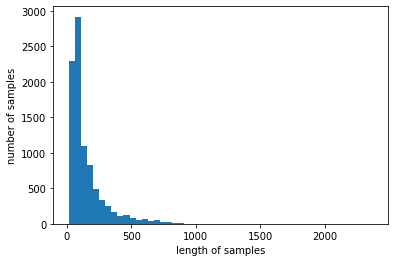

In [3]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

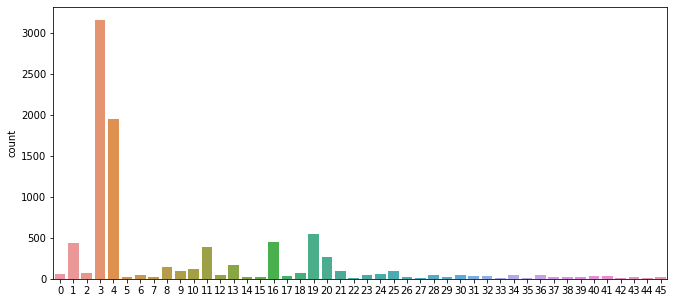

In [4]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

3. 데이터 복원

'단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary -> word_index로 저장

In [5]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

(pad, sos, unk)특별한 토큰 매핑

In [6]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

데이터셋 문자로 복원

In [7]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

print(len(x_train))
print('x_train[5]: ', x_train[:5])

8982
x_train[5]:  ['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share refle

In [8]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))
print('x_test[5]: ', x_test[:5])

2246
x_test[5]:  ['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3', "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman <unk> yulo said yulo told reuters a survey dur

4. 벡터화(DTM, TF-IDF 행렬 사용)

DTM 생성

In [9]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 14227)


TF-IDF Matrix 생성

In [10]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 14227)


테스트 데이터의 TF-IDF Matrix 생성

In [11]:
#테스트 데이터를 DTM으로 변환
x_test_dtm = dtmvector.transform(x_test)

#DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

5. 모델 학습 및 예측, 평가

나이브 베이즈 분류기

In [12]:
# 모델 정의 및 훈련
nb = MultinomialNB()
nb.fit(tfidfv, y_train)

MultinomialNB()

In [13]:
#테스트 데이터에 대한 예측
predicted = nb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6331255565449688


In [14]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.41      0.53        99
          17       0.00    

In [15]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.5498212868794679


CNB

In [16]:
# 모델 정의 및 훈련
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [17]:
#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7720391807658059


In [18]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.65      0.90      0.76       105
           2       0.91      0.50      0.65        20
           3       0.90      0.90      0.90       813
           4       0.76      0.93      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.54      0.71      0.61        83
          12       0.00      0.00      0.00        13
          13       0.60      0.57      0.58        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.68      0.79      0.73        99
          17       0.00    

In [19]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7448186439256785


로지스틱 회귀

In [20]:
# 모델 정의 및 훈련
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [21]:
#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8147818343722173


In [22]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.79      0.76       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.92       813
           4       0.81      0.87      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.85      0.88      0.86        25
          10       0.93      0.87      0.90        30
          11       0.68      0.72      0.70        83
          12       0.62      0.38      0.48        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.70      0.77      0.73        99
          17       0.82    

In [23]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.809871785370617


서포트 벡터 머신

In [24]:
# 모델 정의 및 훈련
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [25]:
#테스트 데이터에 대한 예측
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7818343722172751


In [26]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.72      0.74      0.73       105
           2       0.60      0.60      0.60        20
           3       0.90      0.91      0.91       813
           4       0.80      0.84      0.81       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.33      0.50         3
           8       0.59      0.68      0.63        38
           9       0.88      0.84      0.86        25
          10       0.96      0.77      0.85        30
          11       0.65      0.75      0.70        83
          12       0.44      0.31      0.36        13
          13       0.62      0.54      0.58        37
          14       1.00      0.50      0.67         2
          15       0.67      0.44      0.53         9
          16       0.66      0.73      0.69        99
          17       0.83    

In [27]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7774087362822074


결정 트리

In [28]:
# 모델 정의 및 훈련
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [29]:
#테스트 데이터에 대한 예측
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6193232413178985


In [30]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.73      0.42      0.53       105
           2       0.75      0.45      0.56        20
           3       0.94      0.83      0.88       813
           4       0.40      0.91      0.55       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.86      0.80      0.83        30
          11       0.64      0.49      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.61      0.82      0.70        99
          17       0.00    

In [31]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.5755585664009136


랜덤 포레스트

In [32]:
# 모델 정의 및 훈련
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [33]:
#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6714158504007124


In [34]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33        12
           1       0.42      0.69      0.52       105
           2       0.13      0.10      0.11        20
           3       0.81      0.90      0.85       813
           4       0.65      0.85      0.74       474
           5       0.00      0.00      0.00         5
           6       0.83      0.36      0.50        14
           7       0.50      0.67      0.57         3
           8       0.62      0.53      0.57        38
           9       0.71      0.40      0.51        25
          10       0.60      0.20      0.30        30
          11       0.45      0.51      0.47        83
          12       0.60      0.23      0.33        13
          13       0.40      0.22      0.28        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.55      0.46      0.50        99
          17       0.00    

In [35]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.6406930098492383


그래디언트 부스팅 트리

In [36]:
# 모델 정의 및 훈련
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [37]:
#테스트 데이터에 대한 예측
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


In [38]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.79      0.70      0.74       105
           2       0.62      0.65      0.63        20
           3       0.88      0.91      0.89       813
           4       0.78      0.84      0.81       474
           5       0.00      0.00      0.00         5
           6       0.83      0.71      0.77        14
           7       1.00      0.67      0.80         3
           8       0.59      0.63      0.61        38
           9       0.86      0.76      0.81        25
          10       0.86      0.80      0.83        30
          11       0.64      0.67      0.66        83
          12       0.35      0.54      0.42        13
          13       0.54      0.41      0.46        37
          14       0.08      0.50      0.13         2
          15       0.38      0.33      0.35         9
          16       0.72      0.74      0.73        99
          17       0.56    

In [39]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7679654864390242


보팅

In [40]:
# 개별 분류기 정의
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
complement_nb = ComplementNB()
gradient_boost = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('lr', log_reg), ('cnb', complement_nb), ('gb', gradient_boost)],
    voting='soft'
)

voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('cnb', ComplementNB()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [41]:
#테스트 데이터에 대한 예측
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7938557435440784


In [42]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.78      0.72      0.75       105
           2       0.68      0.65      0.67        20
           3       0.92      0.93      0.92       813
           4       0.75      0.86      0.80       474
           5       0.00      0.00      0.00         5
           6       0.91      0.71      0.80        14
           7       0.67      0.67      0.67         3
           8       0.74      0.66      0.69        38
           9       0.96      0.88      0.92        25
          10       0.93      0.83      0.88        30
          11       0.70      0.73      0.72        83
          12       0.50      0.46      0.48        13
          13       0.63      0.51      0.57        37
          14       0.10      0.50      0.17         2
          15       0.17      0.11      0.13         9
          16       0.73      0.77      0.75        99
          17       0.67    

In [43]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7915569286716847


## step 3 - 2. 빈도수 상위 20,000개의 단어만 사용

1. 데이터 다운

In [44]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=20000, test_split=0.2)

2. 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


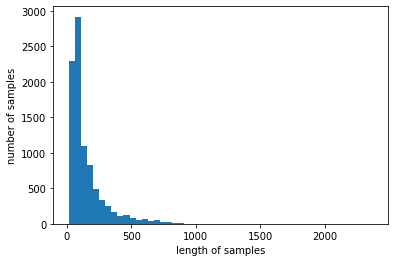

In [45]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

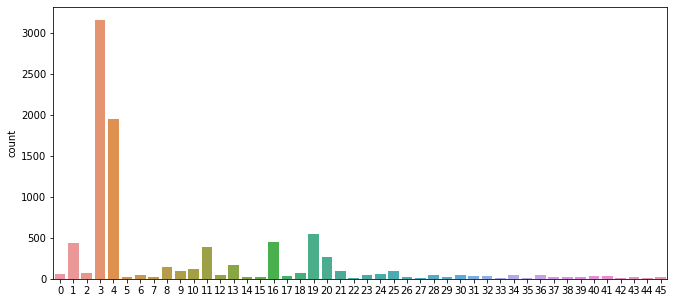

In [46]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

3. 데이터 복원

'단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary -> word_index로 저장

In [47]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

(pad, sos, unk)특별한 토큰 매핑

In [48]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

데이터셋 문자로 복원

In [49]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

print(len(x_train))
print('x_train[5]: ', x_train[:5])

8982
x_train[5]:  ['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt genb br and lt heller overseas corp of chicago have each taken 50 pct stakes in factoring company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share re

In [50]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))
print('x_test[5]: ', x_test[:5])

2246
x_test[5]:  ['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to accommodate growth and expansion plans for waldbaum inc and shopwell inc over the next two years a and p said the acquisition of shopwell in august 1986 and waldbaum in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3', "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman <unk> yulo said yulo told re

4. 벡터화(DTM, TF-IDF 행렬 사용)

DTM 생성

In [51]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 18479)


TF-IDF Matrix 생성

In [52]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 18479)


테스트 데이터의 TF-IDF Matrix 생성

In [53]:
#테스트 데이터를 DTM으로 변환
x_test_dtm = dtmvector.transform(x_test)

#DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

5. 모델 학습 및 예측, 평가

나이브 베이즈 분류기

In [54]:
# 모델 정의 및 훈련
nb = MultinomialNB()
nb.fit(tfidfv, y_train)

MultinomialNB()

In [55]:
#테스트 데이터에 대한 예측
predicted = nb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6193232413178985


In [56]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.39      0.52       105
           2       0.00      0.00      0.00        20
           3       0.75      0.92      0.82       813
           4       0.46      0.96      0.62       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.76      0.37      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.74      0.28      0.41        99
          17       0.00    

In [57]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.5315181088041159


CNB

In [58]:
# 모델 정의 및 훈련
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [59]:
#테스트 데이터에 대한 예측
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7671415850400712


In [60]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.64      0.89      0.74       105
           2       0.91      0.50      0.65        20
           3       0.89      0.91      0.90       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.44      0.11      0.17        38
           9       0.82      0.92      0.87        25
          10       0.96      0.73      0.83        30
          11       0.54      0.70      0.61        83
          12       0.00      0.00      0.00        13
          13       0.61      0.54      0.57        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.77      0.71        99
          17       0.00    

In [61]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7390612170450325


로지스틱 회귀

In [62]:
# 모델 정의 및 훈련
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [63]:
#테스트 데이터에 대한 예측
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8156723063223509


In [64]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.79      0.76       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.92       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.85      0.88      0.86        25
          10       0.96      0.90      0.93        30
          11       0.68      0.72      0.70        83
          12       0.62      0.38      0.48        13
          13       0.65      0.65      0.65        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.70      0.77      0.73        99
          17       0.82    

In [65]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.8104596865918853


서포트 벡터 머신

In [66]:
# 모델 정의 및 훈련
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [67]:
#테스트 데이터에 대한 예측
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.794746215494212


In [68]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.72      0.72      0.72       105
           2       0.70      0.70      0.70        20
           3       0.91      0.92      0.92       813
           4       0.82      0.85      0.84       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.60      0.71      0.65        38
           9       0.91      0.84      0.87        25
          10       0.88      0.77      0.82        30
          11       0.68      0.73      0.71        83
          12       0.57      0.31      0.40        13
          13       0.69      0.59      0.64        37
          14       1.00      0.50      0.67         2
          15       0.57      0.44      0.50         9
          16       0.66      0.76      0.71        99
          17       0.83    

In [69]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7905998391762981


결정 트리

In [70]:
# 모델 정의 및 훈련
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [71]:
#테스트 데이터에 대한 예측
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


In [72]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.39      0.51       105
           2       0.50      0.55      0.52        20
           3       0.93      0.85      0.88       813
           4       0.40      0.89      0.55       474
           5       0.00      0.00      0.00         5
           6       0.75      0.21      0.33        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.16      0.28        25
          10       0.89      0.80      0.84        30
          11       0.61      0.61      0.61        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.62      0.83      0.71        99
          17       0.00    

In [73]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.576123209915252


랜덤 포레스트

In [74]:
# 모델 정의 및 훈련
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [75]:
#테스트 데이터에 대한 예측
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6714158504007124


In [76]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.17      0.33      0.23        12
           1       0.40      0.70      0.51       105
           2       0.19      0.20      0.20        20
           3       0.83      0.91      0.87       813
           4       0.65      0.86      0.74       474
           5       0.00      0.00      0.00         5
           6       1.00      0.29      0.44        14
           7       0.33      0.33      0.33         3
           8       0.48      0.42      0.45        38
           9       0.54      0.28      0.37        25
          10       0.53      0.27      0.36        30
          11       0.49      0.57      0.53        83
          12       0.50      0.15      0.24        13
          13       0.43      0.27      0.33        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.56      0.45      0.50        99
          17       0.00    

In [77]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.6408515630206083


그래디언트 부스팅 트리

In [78]:
# 모델 정의 및 훈련
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [79]:
#테스트 데이터에 대한 예측
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


In [80]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.75      0.70      0.72       105
           2       0.65      0.75      0.70        20
           3       0.87      0.91      0.89       813
           4       0.77      0.84      0.81       474
           5       0.50      0.20      0.29         5
           6       0.91      0.71      0.80        14
           7       0.25      0.33      0.29         3
           8       0.60      0.63      0.62        38
           9       0.90      0.76      0.83        25
          10       0.80      0.80      0.80        30
          11       0.62      0.67      0.65        83
          12       0.50      0.46      0.48        13
          13       0.54      0.35      0.43        37
          14       0.14      0.50      0.22         2
          15       0.33      0.33      0.33         9
          16       0.71      0.71      0.71        99
          17       0.56    

In [81]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7647126117421563


보팅

In [82]:
# 개별 분류기 정의
log_reg = LogisticRegression(penalty='l2', solver='liblinear')
complement_nb = ComplementNB()
gradient_boost = GradientBoostingClassifier()

# VotingClassifier 정의
voting_classifier = VotingClassifier(
    estimators=[('lr', log_reg), ('cnb', complement_nb), ('gb', gradient_boost)],
    voting='soft'
)

voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('cnb', ComplementNB()),
                             ('gb', GradientBoostingClassifier())],
                 voting='soft')

In [83]:
#테스트 데이터에 대한 예측
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7983081032947462


In [84]:
# 정밀도, 재현율, F1점수 확인
print(classification_report(y_test, predicted, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.81      0.77      0.79       105
           2       0.71      0.75      0.73        20
           3       0.90      0.93      0.92       813
           4       0.77      0.87      0.82       474
           5       1.00      0.20      0.33         5
           6       0.92      0.79      0.85        14
           7       1.00      0.67      0.80         3
           8       0.67      0.68      0.68        38
           9       0.95      0.80      0.87        25
          10       0.89      0.83      0.86        30
          11       0.69      0.73      0.71        83
          12       0.50      0.46      0.48        13
          13       0.62      0.54      0.58        37
          14       0.12      0.50      0.20         2
          15       0.43      0.33      0.38         9
          16       0.76      0.75      0.75        99
          17       0.67    

In [85]:
# F1 score weighted avg만 평가 하겠음
report = classification_report(y_test, predicted, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.7939743164246056


# step 4. vocab_size마다 accuracy, f1-score(weighted avg) 비교

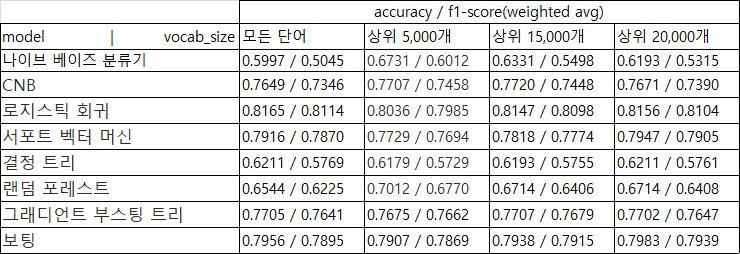

- 위 표를 살펴보면 모든 단어 성능을 상위 15,000개와 상위 20,000개 성능이 비슷 하다는걸 볼 수 있다.

그중 vocab_size가 조금더 작은 상위 15,000개가 가장 적절한 vocab_size라고 생각이 든다.

    -> 상위 20,000개와 성능은 비슷하되 연산수가 조금 더 적기 때문!!

# step 5. 딥러닝 모델과 비교해 보기

1. 데이터 다운

In [88]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=15000, test_split=0.2)

2. 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


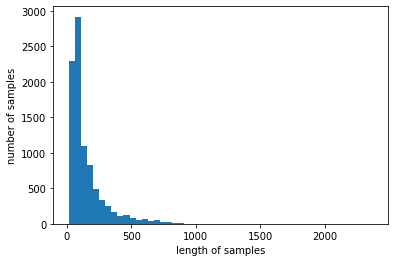

In [89]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

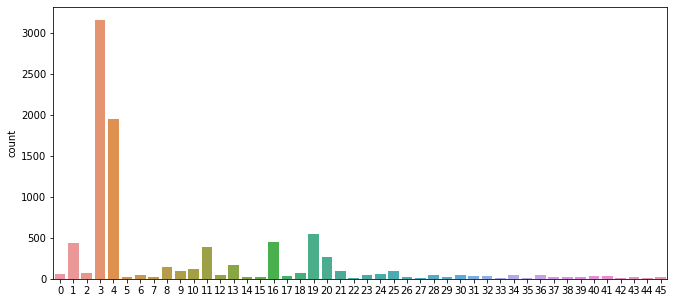

In [90]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

3. 데이터 복원

'단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary -> word_index로 저장

In [91]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

(pad, sos, unk)특별한 토큰 매핑

In [92]:
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

데이터셋 문자로 복원

In [93]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

print(len(x_train))
print('x_train[5]: ', x_train[:5])

8982
x_train[5]:  ['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa belgo factors generale de banque said in a statement it gave no financial details of the transaction sa belgo <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share refle

In [94]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))
print('x_test[5]: ', x_test[:5])

2246
x_test[5]:  ['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3', "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration sra chairman <unk> yulo said yulo told reuters a survey dur

4. 벡터화(DTM, TF-IDF 행렬 사용)

DTM 생성

In [95]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 14227)


TF-IDF Matrix 생성

In [96]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 14227)


테스트 데이터의 TF-IDF Matrix 생성

In [97]:
#테스트 데이터를 DTM으로 변환
x_test_dtm = dtmvector.transform(x_test)

#DTM을 TF-IDF 행렬로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

5. validation set 구성

In [98]:
x_train, x_val, y_train, y_val = train_test_split(x_train_dtm, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  random_state=42)

6. 희소 행렬 -> 밀집 행렬

In [99]:
from scipy import sparse

# 희소 행렬인지 확인
if sparse.issparse(x_train):
    x_train = x_train.toarray()
    x_train = x_train.astype('float32')
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
if sparse.issparse(x_val):
    x_val = x_val.toarray()
    x_val = x_val.astype('float32')
    x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))

In [100]:
x_train.shape

(7185, 14227, 1)

In [101]:
x_val.shape

(1797, 14227, 1)

7. 모델 정의 및 훈련

gru 모델 사용

In [112]:
gru_units = 32
dropout_rate = 0.5

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(gru_units, recurrent_dropout=dropout_rate))
model.add(tf.keras.layers.Dropout(dropout_rate))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(46, activation='softmax'))

# 학습의 진행
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

model.fit(x_train,
          y_train,
          epochs=epochs,
          batch_size=128,
          validation_data=(x_val, y_val),
          verbose=1)

Epoch 1/3
57/57 [==============================] - 2129s 37s/step - loss: 3.2331 - accuracy: 0.2747 - val_loss: 2.4423 - val_accuracy: 0.3534
Epoch 2/3
57/57 [==============================] - 2123s 37s/step - loss: 2.4856 - accuracy: 0.3499 - val_loss: 2.4053 - val_accuracy: 0.3534
Epoch 3/3
57/57 [==============================] - 2114s 37s/step - loss: 2.4644 - accuracy: 0.3488 - val_loss: 2.3970 - val_accuracy: 0.3534


8. 베스트 모델 load 후 테스트 데이터로 평가

희소 행렬 -> 밀집 행렬

In [113]:
if sparse.issparse(x_test_dtm):
    x_test_dtm = x_test_dtm.toarray()
    x_test_dtm = x_test_dtm.astype('float32')
    x_test_dtm = x_test_dtm.reshape((x_test_dtm.shape[0], x_test_dtm.shape[1], 1))

테스트 데이터로 평가

In [114]:
model.evaluate(x_test_dtm, y_test)

71/71 [==============================] - 215s 3s/step - loss: 2.4141 - accuracy: 0.3620


[2.414149045944214, 0.36197686195373535]

예측값을 통한 F1 score weighted avg 값 확인

In [115]:
y_pred = model.predict(x_test_dtm)

In [120]:
y_pred = np.argmax(y_pred, axis=1)

In [121]:
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

Weighted Avg F1-score: 0.19240743851187844


## 머신러닝 모델과 딥러닝 모델 성능 비교

- 머신러닝(로지스틱 회귀)
    - accuracy: 0.8147
    - Weighted Avg F1-score: 0.8098
- 딥러닝 모델(gru 모델)
    - accuracy: 0.3619
    - Weighted Avg F1-score: 0.1924
    
딥러닝 모델이 쓸모없을 정도의 성능을 보임

    - 임베딩 레이어를 제거하고 TF-IDF Matrix로 학습 했는데 성능이 쓰레기!!!!
    - 딥러닝 모델에서 임베딩 레이어(벡터화)가 얼마나 중요한지 느끼게 됨

# 회고

vocab size를 정할 때 직접 실험 해보고 여러 성능을 분석해보는 이런 실험은 해보지 않아서 신기했다.

실험 도중에는 total vocab size가 26,000개가 조금 넘으니까 20,000개 정도가 제일 낫지 않을까 라는 생각을 했는데 내 생각은 틀리고 말았다ㅠ

딥러닝 모델에 임베딩 레이어를 제거하고 TF-IDF Matrix화된 데이터로 학습을 진행 해봤는데 역시 딥러닝 모델에는 벡터화, 즉 임베딩 레이어가 얼마나 중요한지 느끼게 되었다!!!